In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import torch
import numpy as np
import time
from util_hmm_pytorch import *
from util_data import *
from util_plots import *
# from bokeh.plotting import figure, output_notebook, show
# from bokeh.models import Range1d
# from bokeh.io import push_notebook, show, output_notebook
# output_notebook()

In [2]:
## dataset parameters
T = 200 ## sequence length
num_series = 20
dt = 1 ## \delta t
Boundary = 10 ## unit box is amplified by this value, centered at origin
signal_noise_ratio = 0.2 # the noise is multiplied by this param
training_epochs = 50 
D = 2
## Model parameters
K =  4## number of hidden states

In [16]:
## generate time series
x0, y0, init_v, init_v_rand_dir = intialization(T, num_series, Boundary)
final_mus = np.zeros((num_series, K, D))
final_covs = np.zeros((num_series, K, D, D))
STATEs = np.zeros((num_series, T+1, 4))
Disps = np.zeros((num_series, T, D))
As_true = np.zeros((num_series, 4, 4))
As_pred = np.zeros((num_series, K, K))
for s in range(num_series):
    init_state = np.array([x0[s], y0[s], init_v_rand_dir[s, 0], init_v_rand_dir[s, 1]])
    STATEs[s], Disps[s], As_true[s] = generate_data(T, dt, init_state, Boundary, signal_noise_ratio)

In [17]:
## training with one time series at a time, i.e. there are num_series models
for s in range(num_series):
    Y = torch.from_numpy(Disps[s]).float()
    alpha_init_0, alpha_trans_0, m_0, beta_0, nu_0, W_0, alpha_init_hat, alpha_trans_hat, m_ks, beta_ks, nu_ks, W_ks = pirors(Y, T, D, K)
    epoch_elbos = []
    for i in range(training_epochs):
        ## VBE step
        log_gammas, log_eta = vbE_step(alpha_init_hat, alpha_trans_hat, nu_ks, W_ks, m_ks, beta_ks, Y, T, D, K)
        N_ks, Y_ks, S_ks = stats(log_gammas, Y, D, K)
        ## VBM step
        alpha_init_hat, alpha_trans_hat, nu_ks, W_ks, m_ks, beta_ks, cov_ks = vbM_step(log_eta, alpha_init_0, alpha_trans_0, nu_0, W_0, m_0, beta_0, N_ks, Y_ks, S_ks, T, D, K)
    #     epoch_elbo = elbo(log_gammas, log_eta, alpha_init_0, alpha_trans_0, nu_0, W_0, m_0, beta_0, N_ks, Y_ks, S_ks, alpha_init_hat, alpha_trans_hat, nu_ks, W_ks, m_ks, beta_ks, Y, N, D, K)
    #     epoch_elbos.append(epoch_elbo)
    #     print('Iteration:%d, ELBO:%f' % ((i+1), epoch_elbo))
    final_covs[s] = cov_ks ## mean of inverse wishart
    final_mus[s] = m_ks.data.numpy() ## mean of gaussian
    As_pred[s] = alpha_trans_hat.data.numpy()
    print('training : %d' % (s))

training : 0
training : 1
training : 2
training : 3
training : 4
training : 5
training : 6
training : 7
training : 8
training : 9
training : 10
training : 11
training : 12
training : 13
training : 14
training : 15
training : 16
training : 17
training : 18
training : 19


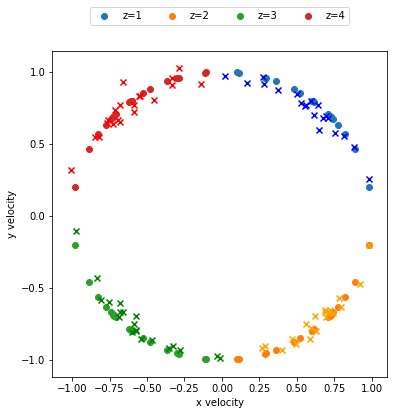

In [18]:
## visualize true velocity and the mean of clusters in gaussian mixture HMM
fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.scatter(init_v[:,0], init_v[:,1], label='z=1')
ax.scatter(init_v[:,0], -init_v[:,1], label='z=2')
ax.scatter(-init_v[:,0], -init_v[:,1], label='z=3')
ax.scatter(-init_v[:,0], init_v[:,1], label='z=4')
colors = ['b', 'orange', 'g', 'r', 'k']
for k in range(K):
    ax.scatter(final_mus[:,k,0], final_mus[:,k,1], c=colors[k], marker='x')
## uncomment these two lines to plot the uncertainty for each point
#     for s in range(num_series):
#         plot_cov_ellipse(cov=final_covs[s, k, :, :], pos=final_mus[s, k, :], nstd=0.3, ax=ax, alpha=0.5)
ax.set_xlabel('x velocity')
ax.set_ylabel('y velocity')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)

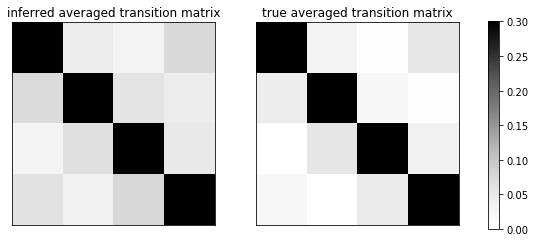

In [24]:
## visualize the averaged transition matrix for groud truth and estimation
"""
   1      2           3     4
  _                         _
  /|     \           /     |\
 /        \         /        \
/         _\|     |/_         \

1 to 2    2 to 1   3 to 2    4 to 3
1 to 4    2 to 3   3 to 4    4 to 1
"""
As_infer, As_true_ave = plot_transition(As_pred, As_true, 0.3)